## Relazioni tra variabili

Fino ad ora abbiamo osservato una variabile alla volta.
In questo capitolo osserveremo le relazioni tra variabili. Due variabili sono relazionate se si può conoscere il valore dato il valore dell'altra.

Per esempio l'altezza di una persona e il suo peso sono relazionate. Le persone più alte tendono a pesare di più. Ovviamente non si tratta di una relazione perfetta, abbiamo persone pesanti basse o persone alte leggere.

### Grafico di  Dispersione (Scatter plot)

La via più semplice per controllare se esite una relazione tra variabili è il **grafico di dispersione**.
Creare un grafico di dispersione non è un lavoro facile, proviamo a visualizzare il grafico che mette in relazione l'altezza con il peso.

Il codice della cella qui sotto legge il dataset ed estrae un campione di 5000 persone

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import readBrfss

df = readBrfss()
sample = df.sample(n=5000, random_state=42)

heights,weights = sample.htm3,sample.wtkg2


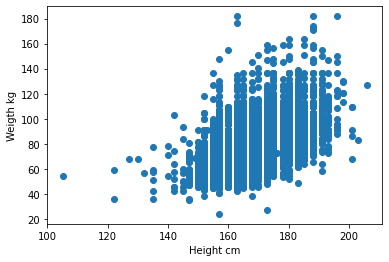

In [4]:
plt.xlabel('Height cm')
plt.ylabel('Weigth kg')
plt.scatter(heights, weights)

Questa non è la miglior rappresentazione in quanto i dati l'altezza delle persone è arrotondata in pollici e poi trasformata in cm e arrotondata ancora. Alcune informazioni vengono perse strada facendo.

Non possiamo recuperare le informazioni, possiamo comunque minimizzare l'effetto sul grafico applicando un lieve disturbo **jitter**

In [5]:
def jitter(values,jitter=0.5):
    n = len(values)
    return np.random.uniform(-jitter,jitter,n) + values

In [6]:
heights1 = jitter(heights,1.3)
weights1 = jitter(weights,0.5)

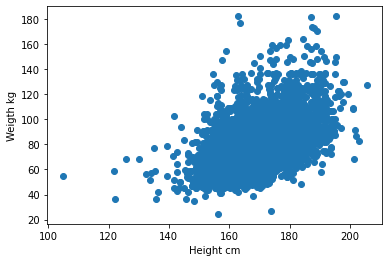

In [7]:
plt.xlabel('Height cm')
plt.ylabel('Weigth kg')
plt.scatter(heights1, weights1)

questo effetto mette meglio in evidenza la relazione, attenzione in generale questa operazione solo per la visualizzazione dei dati.

Abbiamo ancora comunque dei problemi in quanto ci sono molti punti che si sovrappongono che non mostrano le aree più dense e si da risalto ai valori anormali (outliers). Questo effetto si chiama **saturazione**.

Possiamo risolvere questo con il parametro **alpha** che crea dei punti parzialmente trasparenti.



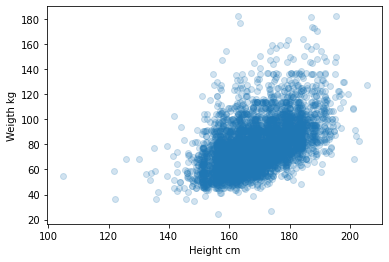

In [8]:
plt.xlabel('Height cm')
plt.ylabel('Weigth kg')
plt.scatter(heights1, weights1,alpha=0.2)

ecco il risultato i punti che si sovrappongono risultano più scuri, dunque le aree più score sono anche le aree più dense.
Questa soluzione funziona bene per dataset con dimensioni moderate, infatto abbiamo scelto un campione di 5000 record su più di 400.000 misure.

Su campioni più grandi si può scegliere l'opzione del grafico hexbin, il quale divide l'area in esagoni e colora ogni bin in base a quanti punti cadono in quella figura.



(30.0, 150.0)

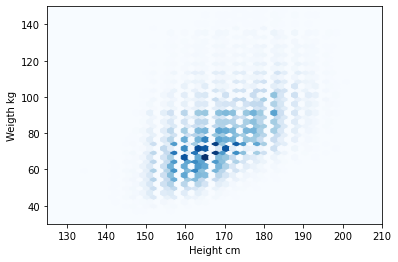

In [9]:
import matplotlib
heights,weights = df.htm3,df.wtkg2

plt.xlabel('Height cm')
plt.ylabel('Weigth kg')
plt.hexbin(heights, weights,cmap=matplotlib.cm.Blues)
plt.xlim([125,210])
plt.ylim([30,150])

## Caratterizzazione delle relazioni

Il grafico a dispersione da un quadro generale della relazione tra variabili, esistono comunque altre visualizzazioni che danno una visione più dettagliata della natura della relazione.

Una opzione è quella di discretizzare una variabile e visualizzare i percentili dell'altra.

Numpy e pandas hanno già delle funzioni pronte per questo:

In [10]:
df = df.dropna(subset=['htm3','wtkg2'])
bins = np.arange(135,210,5)
indices = np.digitize(df.htm3,bins)
groups = df.groupby(indices)

* La funzione `dropna` rimuove le righe con il valore `nan` nelle colonne impostate.
* La funzione `arange` crea un array di valori interi tra il 135 e il 210 (non compreso) con passi di 5 valori.
* La funzione `digitize` calcola l'indice del gruppo che contiene il valore il più basso ha valore 0 mentre il più alto ha valore `len(bins)`.

L'ultima parte è riservata alla funzione `groupby`, pandas restituisce un oggetto `GroubBy` che può essere iterato in un ciclo

In [11]:
for i,group in groups:
    print("L'indice {0} contiene {1} valori".format(i,len(group)))

L'indice 0 contiene 305 valori
L'indice 1 contiene 228 valori
L'indice 2 contiene 477 valori
L'indice 3 contiene 2162 valori
L'indice 4 contiene 18759 valori
L'indice 5 contiene 45761 valori
L'indice 6 contiene 70610 valori
L'indice 7 contiene 72138 valori
L'indice 8 contiene 61725 valori
L'indice 9 contiene 49938 valori
L'indice 10 contiene 43555 valori
L'indice 11 contiene 20077 valori
L'indice 12 contiene 7784 valori
L'indice 13 contiene 1777 valori
L'indice 14 contiene 405 valori
L'indice 15 contiene 131 valori


ora per ogni gruppo possiamo calcolare l'altezza media e funzione di ripartizione CDF del peso

In [12]:
from utils import calcCdf

heights = [group.htm3.mean() for i,group in groups]
cdfs = []
for i,group in groups:
    values,_,vcdf = calcCdf(group.wtkg2) 
    cdfs.append((values,vcdf))

In [13]:
import bisect
def percentile(values,cdf,perc):
    index = bisect.bisect_left(cdf, perc)
    return values[index]

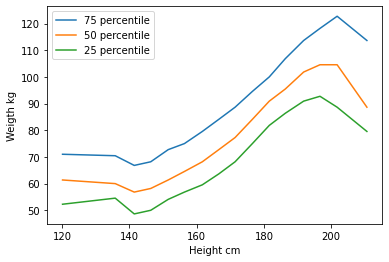

In [14]:
plt.xlabel('Height cm')
plt.ylabel('Weigth kg')

for percent in [75,50,25]:
    weights = [percentile(cdf[0],cdf[1],percent / 100.0) for cdf in cdfs]
    label = "{0} percentile".format(percent)
    plt.plot(heights,weights,label=label)

plt.legend(loc='upper left')

Tra il metro e quanta e i due metri la relazione e approssivamente lineare. Questo range copre il 99% dei valori dunque non serve preoccuparci molto dei valori estremi.

### Correlazione

Una **correlazione** è un valore statistico che intende quantificare la forza della relazione tra due variabili.

La correlazione è una sfida in quanto le variabili che vogliamo comparare non sono espresse nella stessa unità di misura. E anche se sono nella stessa unità possono venire tra distribuzioni differenti.

Ci sono due soluzioni comuni per questo problema:

* Trasformare i valori in un punteggio standard, che rappresenta il numero di deviazioni standard dalla media. Questa trasformazione porta al "Coefficente del prodotto momento Pearson"

* Trasformare ogni valore nel suo rango, che rappresenta l'indice nella lista ordinata del valore associato. Questa trasformazione porta al "Coefficiente di correlazione rango di Spearman"

Se X è una serie di n valori, $x_i$ possiamo standardizzare i valori sottraendo la media e dividendo il risultato per la deviazione standard.

$$z_i = \frac{(x_i - \mu)}{\sigma}$$

Il numeratore è una deviazione: la distanza dalla media. Dividere per $\sigma$ detto anche **standardizzazione** della deviazione, dunque il risultato è un valore adimensionale (nessuna unità) e i valori di questa distribuzione variano tra 0 e 1

Se la distribuzione X è una distribuzione normale allora lo sarà anche Z. Ma se X ha delle code verso sinistra o destra con dei valori anomali questi saranno presenti nella distribuzione normalizzata. In questo caso è meglio creare una nuova variabile R con i valori $r_i$ che variano da 1 a n.

### Covarianza

La covarianza è una misura della tendenza di due variabili a variare assieme. Se abbiamo due serie di valori X e Y la loro deviazione dalla media può essere scritta come:

$$ 
dx_i = x_i - \overline{x}
$$
$$
dy_i = y_i - \overline{y}
$$

se X e Y variano nello stesso modo le loro deviazioni avranno lo stesso segno.
Se moltiplichiamo i due valori i prodotti dello stesso segno avranno un valore positivo altrimenti se l'andamento è opposto avremo un segno negativo

La covarianza è la media dei prodotti:
$$Cov(X,Y) = \frac{1}{n} \sum_{i=1}^n{dx_i dy_i}$$

Se si ha un pochino di pratica in algebra si vedrà che Cov è il prodotto scalare delle deviazioni diviso per il loro numero.
Dunque il valore sarà massimo se i vettori sono identici mentre sarà zero se ortogonali.

proviamo a scrivere questa funzione in codice pyhton

In [15]:
def cov(xs,ys,xmean=None,ymean=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    if xmean is None:
        xmean = np.mean(xs)
    
    if ymean is None:
        ymean = np.mean(ys)
    
    cov = np.dot(xs - xmean,ys - ymean) / len(xs)
    
    return cov

In [16]:
xs = [1,2,3]
ys = [-1,-2,-3]

cov(xs,ys)

-0.6666666666666666

Questa funzione ha solo lo scopo di illustrare la funzione, **Numpy** e **pandas** hanno già pronta la funzione che effettua delle correzioni su piccoli dataset non ancora affrontata.

La funzione `np.cov` da come risultato una matrice, che è molto di più di quello che ci serve.

In [17]:
np.cov(xs,ys)

array([[ 1., -1.],
       [-1.,  1.]])

## Correlazione di Pearson

La covarianza è utile in alcune applicazioni, ma raramente viene usata per riassumere in quanto è difficile da interpretare.
Tra altri problemi, la sua misura rappresenta il prodotto delle unità di X e Y, per esempio la covarianza tra il peso e l'altezza del dataset BRFSS è di 113 kg-cm, qualsiasi cosa voglia dire.

Una soluzione del problema è quella di dividere la deviazione per la deviazione standard, questo ci porta ad una misura con valori standard.

$$
p_i = \frac{(x_i - \overline{x})}{S_x}\frac{(y_i - \overline{y})}{S_y}
$$

La media di questi prodotti può essere scritta come :

$$
\rho = \frac{1}{n} \sum_{i=1}^n{p_i}
$$

che diventa 
$$
\rho = \frac{Cov(X,Y)}{S_x S_y}
$$

Questo valore viene anche chiamato **indice di correlazione di pearson** qui sotto l'implementazione in pyhton

In [18]:
import math
def corr(xs,ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    xmean = np.mean(xs)
    ymean = np.mean(ys)
    
    xvar = np.var(xs)
    yvar = np.var(ys)
    
    corr = cov(xs,ys,xmean,ymean) / math.sqrt(xvar * yvar)
    
    return corr

In [19]:
corr(xs,ys)

-1.0

Questo indice varia tra -1 e 1, la magnitudine indica quanto questa relazione è forte. Con un valore di -1 e 1 siamo nella condizione di perfetta correlazione. Molte correlazioni nel mondo reale non sono perfette, ma sono comunque utili.

La correlazione tra altezza e peso ha come valore 0,51 che per il nostro lavoro sta ad indicare una forte correlazione.

## Relazioni non lineari

Se l'indice di correlazione di Spearman è 0 si è tentati di dire che non esiste relazione tra le due variabili, questa conclusione però può non essere valida.

La correlazione di Spearman misura solo le relazioni lineari. Se la relazione non è lineare $\rho$ sottostima la forza.
Qui sotto una lista di esempi:

![non linear relation](./images/correlation.png)


Per riassimere è sempre meglio controllare tramite un grafico a dispersione i dati invece di fidarci ciecamente del valore.

## Coefficiente di correlazione per ranghi di Spearman

La correlazione di Pearson lavora bene se la relazione tra due variabili è lineare e le due variabili assumono una distribuzione normale. 

Ma questo non funziona bene in presenza di valori anomali. 
Questo coefficiente di correlazione è una alternativa per mitigare gli effetti dei valori anomali. Per calcolare la correlazione di Spearman dobbiamo calcolare il rango di ogni valore. 
Qui sotto l'implentazione in python

In [20]:
import pandas as pd

def spearmancorr(xs,ys):
    xranks = pd.Series(xs)
    yranks = pd.Series(ys)
    
    return corr(xranks,yranks)

In [21]:
spearmancorr(xs,ys)

-1.0

## Correlazione e causalità

Se le variabili A e B sono correlate ci sono tre possibili spiegazioni:

* A causa B
* B causa A
* Oppure un insieme di fattori causa sia A che B

Queste spegazioni sono anche chiamate **relazioni causali**. 
La correlazione da sola non fa distinzione tra le tre spiegazioni, dunque non possiamo sapere quale sia vera.
Si può riassumere tutto il capitoletto con la frase: "La correlazione non implica la causalità".
Questo concetto è talmente importante che ha una pagina wikipedia dedicata, qui il [link](https://en.wikipedia.org/wiki/Correlation_does_not_imply_causation)

Come possiamo dare evidenza di una causalità:

* Controllare l'ordine cronologico degli eventi: se B accade prima di A allora A causa B e non il contrario. L'ordine degli eventi aiuta a dedurre la direzione della causalità. Attenzione però questo non preclude ancora che altri eventi causino sia A che B

* Usare la casualità. Se dividiamo un campione ampio in due gruppi in modo casuale e calcoliamo la media delle variabili ci si aspetta che la differenza dei valori sia piccola. Se i gruppi sono praticamente identici in tutte le variabili tranne una possiamo eliminare la relazione spuria.
 
Queste idee sono alla base dei *Studi clinici randomizzati controllati* nei quali soggetti sono assegnati in modo casuale in due o più gruppi: un gruppo di **trattamento** e un gruppo di **controllo**.
Il primo gruppo riceve l'intervento come ad esempio un farmaco mentre nel secondo gruppo di controllo non viene fatto alcun intervento o in intervento per cui gli effetti sono noti.

Sfortunatamente questo tipo di test sono possibili solo nei test di laboratorio e nella medicina, nelle scienze sociali questo tipo di esperimenti non sono molte volte fattibili per problemi etici.

Una alternativa è quella di ricorrere agli **Esperimenti Natuali** dove i "differenti" trattamenti viene riservato a gruppi di elementi simili. 

Un problema degli esperimenti naturali è che gli individui potrebbero variare in modi che al momento non sono apparenti.

In alcuni casi è possibile dedurre una relazione usando la analisi di regressione, vedremo questo in un capitolo a parte.